In [1]:
import pandas as pd
from joblib import load, dump

from sklearn.ensemble import RandomForestClassifier
import optuna
from sklearn.model_selection import train_test_split

from sklearn.metrics import confusion_matrix, precision_score, accuracy_score, f1_score, recall_score, matthews_corrcoef

/home/david/miniconda3/envs/mate_ciencias2024/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def get_class_metrics(y_true=None, y_pred=None):
    row = [
        accuracy_score(y_true=y_true, y_pred=y_pred), 
        precision_score(y_true=y_true, y_pred=y_pred), 
        recall_score(y_true=y_true, y_pred=y_pred), 
        confusion_matrix(y_true=y_true, y_pred=y_pred), 
        f1_score(y_true=y_true, y_pred=y_pred)
    ]

    return row

In [3]:
def get_metrics(y_true=None, y_predict=None, name_model=""):
    row = [
        name_model,
        precision_score(y_pred=y_predict, y_true=y_true),
        accuracy_score(y_true=y_true, y_pred=y_predict),
        recall_score(y_true=y_true, y_pred=y_predict),
        f1_score(y_true=y_true, y_pred=y_predict),
        matthews_corrcoef(y_true=y_true, y_pred=y_predict),
    ]
    return row

In [4]:
df_train = pd.read_csv("../../results/4_train_dataset.csv")
df_test_mix = pd.read_csv("../../results/4_testing_mix.csv")
df_test_neg = pd.read_csv("../../results/4_testing_negatives.csv")

In [5]:
scaler = load("../../results/scaler_process.joblib")

In [6]:
response = df_train["stroke"].values
df_values = df_train.drop(columns=["stroke"]).values

X_train, X_val, y_train, y_val = train_test_split(df_values, response, test_size=.3, random_state=42)

In [7]:
matrix_data = []

for n in [50, 100, 150, 200, 250, 500, 1000]:
    for criterion in ["gini", "entropy"]:
        rf_class = RandomForestClassifier(
            n_estimators=n,
            criterion=criterion,
            random_state=42
        )
        rf_class.fit(X_train, y_train)

        rf_predict_val = rf_class.predict(X_val)

        row = get_metrics(y_true=y_val, y_predict=rf_predict_val, name_model="RF")
        row.insert(1, n)
        row.insert(1, criterion)

        matrix_data.append(row)

df_performance_val = pd.DataFrame(data=matrix_data, columns=["name_model", "Criterion", "N-estimators", "precision_score", "accuracy_score", "recall_score", "f1_score", "matthews_corrcoef"])

In [8]:
df_performance_val.sort_values(by=["precision_score"], ascending=False)

,name_model,Criterion,N-estimators,precision_score,accuracy_score,recall_score,f1_score,matthews_corrcoef
1,RF,entropy,50,0.759036,0.766917,0.851351,0.802548,0.525533
13,RF,entropy,1000,0.750000,0.759398,0.851351,0.797468,0.510243
11,RF,entropy,500,0.750000,0.759398,0.851351,0.797468,0.510243
12,RF,gini,1000,0.746988,0.751880,0.837838,0.789809,0.494288
7,RF,entropy,200,0.741176,0.751880,0.851351,0.792453,0.494956
10,RF,gini,500,0.738095,0.744361,0.837838,0.784810,0.478869
5,RF,entropy,150,0.732558,0.744361,0.851351,0.787500,0.479662
9,RF,entropy,250,0.732558,0.744361,0.851351,0.787500,0.479662
2,RF,gini,100,0.729412,0.736842,0.837838,0.779874,0.463444
3,RF,entropy,100,0.729412,0.736842,0.837838,0.779874,0.463444


In [9]:
from sklearn.model_selection import cross_validate

In [10]:
def select_algorithm(trial):
    options_criterion = trial.suggest_categorical("criterion", ['gini', 'entropy', 'log_loss'])
    options_n_estimators = trial.suggest_int("n_estimators", 10, 3000)
    options_min_samples_split = trial.suggest_int("min_samples_split", 2, 30)
    
    model = RandomForestClassifier(
        random_state=42,
        n_estimators=options_n_estimators,
        criterion=options_criterion,
        min_samples_split=options_min_samples_split
    )

    return model

In [11]:
metrics_list = ["accuracy", "recall", "precision", "f1"]

In [12]:
def objective(trial):
    classifier_obj = select_algorithm(trial)
    scores = cross_validate(classifier_obj, X_train, y_train, cv=5, scoring=metrics_list)
    return scores["test_precision"].mean() #puede ser recall

In [13]:
trials = 10

algorithm = "RandomForestClassifier"

study = optuna.create_study(directions=["maximize"])
study.optimize(objective, n_trials=trials)
model = eval(f"{algorithm}(**study.best_params)")
model.fit(X_train, y_train)
response_cv = cross_validate(model, X_train, y_train, cv=5,
                                    scoring=["accuracy", "precision", "f1", "recall"])

[I 2024-10-15 20:28:04,481] A new study created in memory with name: no-name-342d78f6-da49-41d5-8c96-055df048e67c
[I 2024-10-15 20:28:21,369] Trial 0 finished with value: 0.7463071618342181 and parameters: {'criterion': 'entropy', 'n_estimators': 2462, 'min_samples_split': 20}. Best is trial 0 with value: 0.7463071618342181.
[I 2024-10-15 20:28:40,108] Trial 1 finished with value: 0.7463071618342181 and parameters: {'criterion': 'log_loss', 'n_estimators': 2865, 'min_samples_split': 18}. Best is trial 0 with value: 0.7463071618342181.
[I 2024-10-15 20:28:48,676] Trial 2 finished with value: 0.7358295240221151 and parameters: {'criterion': 'entropy', 'n_estimators': 1152, 'min_samples_split': 13}. Best is trial 0 with value: 0.7463071618342181.
[I 2024-10-15 20:28:58,033] Trial 3 finished with value: 0.7361543197306706 and parameters: {'criterion': 'gini', 'n_estimators': 1510, 'min_samples_split': 9}. Best is trial 0 with value: 0.7463071618342181.
[I 2024-10-15 20:29:09,811] Trial 4 f

In [14]:
str(study.best_params)

"{'criterion': 'entropy', 'n_estimators': 2462, 'min_samples_split': 20}"

In [15]:
import numpy as np

y_pred = model.predict(X_val)
    
cv_accuracy = np.mean(response_cv["test_accuracy"])
cv_precision = np.mean(response_cv["test_precision"])
cv_f1 = np.mean(response_cv["test_f1"])
cv_recall = np.mean(response_cv["test_recall"])

row_training = [cv_accuracy, cv_precision, cv_f1, cv_recall]
get_class_metrics(y_pred=y_pred, y_true=y_val)

[0.7443609022556391,
 np.float64(0.717391304347826),
 np.float64(0.8918918918918919),
 array([[33, 26],
        [ 8, 66]]),
 np.float64(0.7951807228915663)]

In [16]:
row_training

[np.float64(0.7993125330512957),
 np.float64(0.7463071618342181),
 np.float64(0.7977396271379728),
 np.float64(0.8608374384236454)]

In [17]:
from sklearn.metrics import RocCurveDisplay, ConfusionMatrixDisplay

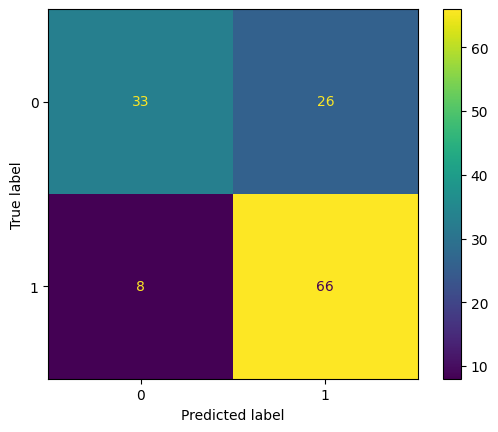

In [18]:
ConfusionMatrixDisplay.from_estimator(model, X_val, y_val)

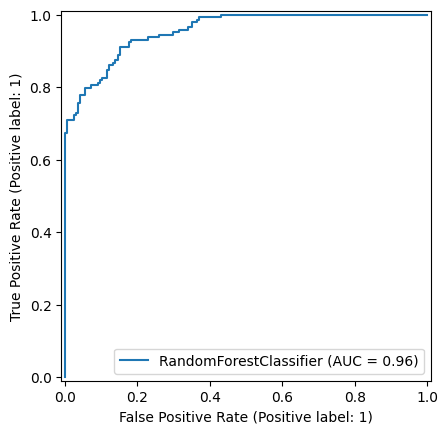

In [19]:
RocCurveDisplay.from_estimator(model, X_train, y_train)

In [20]:
from tpot import TPOTClassifier

/home/david/miniconda3/envs/mate_ciencias2024/lib/python3.9/site-packages/tpot/builtins/__init__.py:36: UserWarning: Warning: optional dependency `torch` is not available. - skipping import of NN models.
  warnings.warn("Warning: optional dependency `torch` is not available. - skipping import of NN models.")


In [21]:
tpot = TPOTClassifier(verbosity=2, max_time_mins=10)
tpot.fit(X_train, y_train)
print(tpot.score(X_val, y_val))
tpot.export('tpot_demo.py')

                                                                              
Generation 1 - Current best internal CV score: 0.818667371760973
                                                                              
Generation 2 - Current best internal CV score: 0.818667371760973
                                                                              
Generation 3 - Current best internal CV score: 0.818667371760973
                                                                              
Generation 4 - Current best internal CV score: 0.818667371760973
                                                                              
Generation 5 - Current best internal CV score: 0.818667371760973
                                                                              
Generation 6 - Current best internal CV score: 0.818667371760973
                                                                              
Generation 7 - Current best internal CV score: 0.81882601